# Introduction

trackintel documentation: https://trackintel.readthedocs.io/en/latest/modules/model.html#trackintel.Positionfixes

trackintel tutorial: https://github.com/mie-lab/trackintel/blob/master/examples/trackintel_basic_tutorial.ipynb

In [ ]:
!pip install trackintel

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

from collections import defaultdict
from datetime import timedelta
from matplotlib import pyplot as plt
from multiprocessing import Pool
from shapely.geometry import LineString
from shapely.geometry import Point

import trackintel as ti

In [4]:
cityB = pd.read_csv('cityB_hiroshima.csv')
cityB.head()

,uid,d,t,x,y
0,0,0,20,80,99
1,0,0,21,81,97
2,0,0,25,83,102
3,0,0,26,80,101
4,0,0,27,80,101


In [6]:
cityB.shape

(24375898, 5)

In [8]:
cityB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24375898 entries, 0 to 24375897
Data columns (total 5 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int64
 1   d       int64
 2   t       int64
 3   x       int64
 4   y       int64
dtypes: int64(5)
memory usage: 929.9 MB


`d`: Days since start of the data collection, ranges from 0-74 (the data is collected over 75 days)   
`t`: Ranges from 0-47 (the data is collected every 30 mins, there is 48 such periods in 1 day)

# Data Preprocessing

Limit the data to only the first month's data (30 days), i.e. `d` < 30.

In [10]:
cityB = cityB[cityB['d'] < 30]

In [12]:
cityB.shape

(9736068, 5)

In [14]:
# Save to a temporary file for later use
cityB.to_csv('cityB_filtered.csv', index=False)

Here, we define an arbitrary start date of the data collected.

In [15]:
# Define the start date
start_date = pd.to_datetime("2024-01-01")

In [16]:
def preprocess_data(data, start_date):
    # Create Point geometries
    geometry = [Point(xy) for xy in zip(data['x'], data['y'])]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=geometry)
    gdf.set_crs(epsg=3857, inplace=True)

    # Convert 'd' (days since start) to actual date
    gdf['date'] = start_date + pd.to_timedelta(gdf['d'], unit='D')
    
    # Convert 't' (30-minute intervals) to time of day
    gdf['time'] = pd.to_timedelta(gdf['t'] * 30, unit='m')  # Each 't' is multiplied by 30 minutes
    
    # Combine 'date' and 'time' into a single datetime column
    gdf['datetime'] = gdf['date'] + gdf['time']

    return gdf

In [20]:
def remove_consecutive_duplicates(sequence):
    """Remove consecutive duplicate coordinates from a sequence."""
    cleaned_sequence = [sequence[0]]  # Start with the first element
    for i in range(1, len(sequence)):
        if sequence[i] != sequence[i - 1]:  # Only add if different from the previous point
            cleaned_sequence.append(sequence[i])
    return cleaned_sequence

def preprocess_tripleg(dataset):
    """Preprocess each tripleg in the dataset by removing consecutive duplicates."""
    return [remove_consecutive_duplicates(sequence) for sequence in dataset]

In [22]:
def split_triplegs(triplegs, max_length):
    processed_triplegs = []
    for tripleg in triplegs:      
        # Split if the cleaned tripleg is too long
        if len(tripleg) > max_length:
            for i in range(0, len(tripleg), max_length):
                processed_triplegs.append(tripleg[i:i + max_length])
        else:
            processed_triplegs.append(tripleg)
    return processed_triplegs

# GSP Algorithm

In [24]:
class GSP:
    def __init__(self, sequences, min_support):
        self.sequences = sequences          # List of sequences with coordinate pairs
        self.min_support = min_support      # Minimum support threshold
        self.frequent_patterns = []         # Store all found frequent patterns

    def is_subsequence(self, candidate, sequence):
        candidate_index = 0  # Start with the first element of candidate
        for item in sequence:
            if item == candidate[candidate_index]:  # Check if current item matches the current candidate element
                candidate_index += 1  # Move to the next element in candidate
                if candidate_index == len(candidate):  # If we matched all elements in candidate, it's a subsequence
                    return True
        return False  # If we finish the loop without matching all of candidate, return False
    
    def count_support(self, candidates):
        """
        Count the support of each candidate in the sequences
        """
        support_count = defaultdict(int)
        for sequence in self.sequences:
            # Filter out sequences that are too short to contain any candidates of the current length
            if len(sequence) < len(next(iter(candidates))):  # All candidates are of the same length
                continue
                
            for candidate in candidates:
                if support_count[candidate] >= min_support: # Early stopping: stop counting if min_support is reached
                    continue
                    
                if self.is_subsequence(candidate, sequence):
                    support_count[candidate] += 1

        # Filter out candidates that meet minimum support threshold
        support_count = {seq: count for seq, count in support_count.items() if count >= self.min_support}
        return support_count

    def generate_candidates(self, prev_frequent_patterns, k):
        """Generate candidate sequences of a specified length by merging sequences with common prefixes/suffixes.
        Includes Apriori check to remove candidate sequences with any non-frequent subsequence.
        """
        candidates = set()
        for pattern1 in prev_frequent_patterns:
            for pattern2 in prev_frequent_patterns:
                if pattern1 == pattern2: # Don't merge the same sequences
                    continue
                # Merge two sequences if they share k-1 items
                if pattern1[1:] == pattern2[:-1]:  # Ensure that only relevant sequences are merged
                    candidate = pattern1 + (pattern2[-1],)
                    # Apriori check: Keep only if all (k-1) subsequences are frequent
                    if all(candidate[i:i+k-1] in prev_frequent_patterns for i in range(len(candidate) - k + 1)):
                        candidates.add(candidate)
                        
        return candidates

    def run(self):
        """
        Run the GSP algorithm
        """
        # Step 1: Find frequent 1-sequences (individual locations)
        all_items = set(item for sequence in self.sequences for item in sequence)
        initial_candidates = [(item,) for item in all_items]
        frequent_patterns = self.count_support(initial_candidates)
        
        # Add to result list
        self.frequent_patterns.extend(frequent_patterns.items())
        print("1-itemsets done!")
        
        k = 2  # Start with 2-sequences

        while frequent_patterns:
            # Step 2: Generate candidate k-sequences (those with infrequent subsequences are removed)
            candidates = self.generate_candidates(frequent_patterns.keys(), k)
            if not candidates: # Break if no new candidates are generated
                print(f"No new candidates generated. Stopping at {k-1}-itemsets")
                break
            
            # Step 3: Count support for each candidate (those that do not meet min_support are removed)
            frequent_patterns = self.count_support(candidates)
            
            # Add found frequent patterns to result list
            if frequent_patterns:
                self.frequent_patterns.extend(frequent_patterns.items())
                print(f"{k}-itemsets done!")
            
            # Move to the next level
            k += 1

        return self.frequent_patterns

In [26]:
# Define constants
chunk_size = 100000  # Number of rows to load per chunk
min_support = 10  # Minimum support for frequent patterns
gap_threshold_sp = 45  # Gap threshold for staypoint detection
gap_threshold_trip = 45 # Gap threshold for triplegs generation
dist_threshold = 10  # Distance threshold for staypoints
max_tripleg_length = 10 # Maximum length of each tripleg

In [28]:
# Dictionary to store patterns by chunk
all_frequent_patterns = defaultdict(list)

In [30]:
# Process data in chunks
for chunk in pd.read_csv('cityB_filtered.csv', chunksize=chunk_size):
    # Preprocess each chunk
    gdf_chunk = preprocess_data(chunk, start_date)
    
    # Generate position fixes and triplegs
    pfs_chunk = ti.io.read_positionfixes_gpd(gdf_chunk, tracked_at="datetime", user_id="uid", geom_col="geometry", tz='Asia/Tokyo')
    pfs_chunk, sp_chunk = pfs_chunk.as_positionfixes.generate_staypoints(gap_threshold=gap_threshold_sp, dist_threshold=dist_threshold, 
                                                                         print_progress=True)
    pfs_chunk, tpls_chunk = pfs_chunk.generate_triplegs(staypoints=sp_chunk, method='overlap_staypoints', gap_threshold=gap_threshold_trip)

    print(gdf_chunk[:5])
    
    # Convert triplegs to sequences
    tpls_chunk['tripleg_list'] = tpls_chunk['geom'].apply(lambda geom: list(geom.coords))
    tripleg_list = tpls_chunk['tripleg_list'].tolist()
    
    # Preprocess triplegs by removing consecutive duplicates
    processed_triplegs = preprocess_tripleg(tripleg_list)
    splitted_triplegs = split_triplegs(processed_triplegs, 10)
    
    # Apply GSP on each chunk and collect patterns
    gsp = GSP(splitted_triplegs, min_support)
    frequent_patterns_chunk = gsp.run()
    all_frequent_patterns.update(frequent_patterns_chunk)

100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:09<00:00, 23.09it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

   uid  d   t   x    y                geometry       date            time  \
0    0  0  20  80   99   POINT (80.000 99.000) 2024-01-01 0 days 10:00:00   
1    0  0  21  81   97   POINT (81.000 97.000) 2024-01-01 0 days 10:30:00   
2    0  0  25  83  102  POINT (83.000 102.000) 2024-01-01 0 days 12:30:00   
3    0  0  26  80  101  POINT (80.000 101.000) 2024-01-01 0 days 13:00:00   
4    0  0  27  80  101  POINT (80.000 101.000) 2024-01-01 0 days 13:30:00   

             datetime  
0 2024-01-01 10:00:00  
1 2024-01-01 10:30:00  
2 2024-01-01 12:30:00  
3 2024-01-01 13:00:00  
4 2024-01-01 13:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:09<00:00, 23.83it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

        uid   d   t   x    y                geometry       date  \
100000  225  12  34  97  107  POINT (97.000 107.000) 2024-01-13   
100001  225  12  35  96  100  POINT (96.000 100.000) 2024-01-13   
100002  225  12  36  96  102  POINT (96.000 102.000) 2024-01-13   
100003  225  12  37  97  115  POINT (97.000 115.000) 2024-01-13   
100004  225  13  17  97  115  POINT (97.000 115.000) 2024-01-14   

                  time            datetime  
100000 0 days 17:00:00 2024-01-13 17:00:00  
100001 0 days 17:30:00 2024-01-13 17:30:00  
100002 0 days 18:00:00 2024-01-13 18:00:00  
100003 0 days 18:30:00 2024-01-13 18:30:00  
100004 0 days 08:30:00 2024-01-14 08:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:09<00:00, 24.68it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

        uid   d   t   x    y                geometry       date  \
200000  450  22  21  44  108  POINT (44.000 108.000) 2024-01-23   
200001  450  22  22  45  108  POINT (45.000 108.000) 2024-01-23   
200002  450  22  23  45  109  POINT (45.000 109.000) 2024-01-23   
200003  450  22  24  44  109  POINT (44.000 109.000) 2024-01-23   
200004  450  22  25  45  109  POINT (45.000 109.000) 2024-01-23   

                  time            datetime  
200000 0 days 10:30:00 2024-01-23 10:30:00  
200001 0 days 11:00:00 2024-01-23 11:00:00  
200002 0 days 11:30:00 2024-01-23 11:30:00  
200003 0 days 12:00:00 2024-01-23 12:00:00  
200004 0 days 12:30:00 2024-01-23 12:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:08<00:00, 26.75it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

        uid   d   t    x    y                 geometry       date  \
300000  680  20  27  194  192  POINT (194.000 192.000) 2024-01-21   
300001  680  20  28  190  194  POINT (190.000 194.000) 2024-01-21   
300002  680  20  30  196  192  POINT (196.000 192.000) 2024-01-21   
300003  680  20  31  190  194  POINT (190.000 194.000) 2024-01-21   
300004  680  20  32  197  193  POINT (197.000 193.000) 2024-01-21   

                  time            datetime  
300000 0 days 13:30:00 2024-01-21 13:30:00  
300001 0 days 14:00:00 2024-01-21 14:00:00  
300002 0 days 15:00:00 2024-01-21 15:00:00  
300003 0 days 15:30:00 2024-01-21 15:30:00  
300004 0 days 16:00:00 2024-01-21 16:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 26.05it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

        uid   d   t    x   y                geometry       date  \
400000  907   9  44  186  22  POINT (186.000 22.000) 2024-01-10   
400001  907   9  45  190  44  POINT (190.000 44.000) 2024-01-10   
400002  907  10  14  189  56  POINT (189.000 56.000) 2024-01-11   
400003  907  10  27  198  38  POINT (198.000 38.000) 2024-01-11   
400004  907  10  28  190  56  POINT (190.000 56.000) 2024-01-11   

                  time            datetime  
400000 0 days 22:00:00 2024-01-10 22:00:00  
400001 0 days 22:30:00 2024-01-10 22:30:00  
400002 0 days 07:00:00 2024-01-11 07:00:00  
400003 0 days 13:30:00 2024-01-11 13:30:00  
400004 0 days 14:00:00 2024-01-11 14:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:08<00:00, 27.13it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

         uid   d   t   x    y                geometry       date  \
500000  1142  17  13  57  152  POINT (57.000 152.000) 2024-01-18   
500001  1142  17  14  57  153  POINT (57.000 153.000) 2024-01-18   
500002  1142  17  15  57  152  POINT (57.000 152.000) 2024-01-18   
500003  1142  17  16  57  151  POINT (57.000 151.000) 2024-01-18   
500004  1142  17  17  57  152  POINT (57.000 152.000) 2024-01-18   

                  time            datetime  
500000 0 days 06:30:00 2024-01-18 06:30:00  
500001 0 days 07:00:00 2024-01-18 07:00:00  
500002 0 days 07:30:00 2024-01-18 07:30:00  
500003 0 days 08:00:00 2024-01-18 08:00:00  
500004 0 days 08:30:00 2024-01-18 08:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:08<00:00, 26.99it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

         uid  d   t   x   y               geometry       date            time  \
600000  1385  6  13  84  97  POINT (84.000 97.000) 2024-01-07 0 days 06:30:00   
600001  1385  6  28  84  97  POINT (84.000 97.000) 2024-01-07 0 days 14:00:00   
600002  1385  7  33  83  97  POINT (83.000 97.000) 2024-01-08 0 days 16:30:00   
600003  1385  7  34  79  86  POINT (79.000 86.000) 2024-01-08 0 days 17:00:00   
600004  1385  7  35  90  80  POINT (90.000 80.000) 2024-01-08 0 days 17:30:00   

                  datetime  
600000 2024-01-07 06:30:00  
600001 2024-01-07 14:00:00  
600002 2024-01-08 16:30:00  
600003 2024-01-08 17:00:00  
600004 2024-01-08 17:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [00:08<00:00, 29.10it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

         uid   d   t    x    y                 geometry       date  \
700000  1621  12  33  151  149  POINT (151.000 149.000) 2024-01-13   
700001  1621  12  34  135  111  POINT (135.000 111.000) 2024-01-13   
700002  1621  12  35   93   82    POINT (93.000 82.000) 2024-01-13   
700003  1621  12  36   81   94    POINT (81.000 94.000) 2024-01-13   
700004  1621  12  37   81   93    POINT (81.000 93.000) 2024-01-13   

                  time            datetime  
700000 0 days 16:30:00 2024-01-13 16:30:00  
700001 0 days 17:00:00 2024-01-13 17:00:00  
700002 0 days 17:30:00 2024-01-13 17:30:00  
700003 0 days 18:00:00 2024-01-13 18:00:00  
700004 0 days 18:30:00 2024-01-13 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:08<00:00, 28.92it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

         uid   d   t   x   y               geometry       date  \
800000  1870  11  31  86  91  POINT (86.000 91.000) 2024-01-12   
800001  1870  11  36  86  90  POINT (86.000 90.000) 2024-01-12   
800002  1870  12   7  88  94  POINT (88.000 94.000) 2024-01-13   
800003  1870  12   8  90  92  POINT (90.000 92.000) 2024-01-13   
800004  1870  12   9  90  94  POINT (90.000 94.000) 2024-01-13   

                  time            datetime  
800000 0 days 15:30:00 2024-01-12 15:30:00  
800001 0 days 18:00:00 2024-01-12 18:00:00  
800002 0 days 03:30:00 2024-01-13 03:30:00  
800003 0 days 04:00:00 2024-01-13 04:00:00  
800004 0 days 04:30:00 2024-01-13 04:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:08<00:00, 27.28it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

         uid  d   t   x    y                geometry       date  \
900000  2119  3  31  74   87   POINT (74.000 87.000) 2024-01-04   
900001  2119  3  33  71   94   POINT (71.000 94.000) 2024-01-04   
900002  2119  3  34  67  101  POINT (67.000 101.000) 2024-01-04   
900003  2119  3  44  58  112  POINT (58.000 112.000) 2024-01-04   
900004  2119  4  17  58  111  POINT (58.000 111.000) 2024-01-05   

                  time            datetime  
900000 0 days 15:30:00 2024-01-04 15:30:00  
900001 0 days 16:30:00 2024-01-04 16:30:00  
900002 0 days 17:00:00 2024-01-04 17:00:00  
900003 0 days 22:00:00 2024-01-04 22:00:00  
900004 0 days 08:30:00 2024-01-05 08:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:08<00:00, 26.91it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t   x    y                geometry       date  \
1000000  2362  8   6  46  138  POINT (46.000 138.000) 2024-01-09   
1000001  2362  8  12  46  138  POINT (46.000 138.000) 2024-01-09   
1000002  2362  8  13  47  122  POINT (47.000 122.000) 2024-01-09   
1000003  2362  8  22  49  120  POINT (49.000 120.000) 2024-01-09   
1000004  2362  8  23  46  128  POINT (46.000 128.000) 2024-01-09   

                   time            datetime  
1000000 0 days 03:00:00 2024-01-09 03:00:00  
1000001 0 days 06:00:00 2024-01-09 06:00:00  
1000002 0 days 06:30:00 2024-01-09 06:30:00  
1000003 0 days 11:00:00 2024-01-09 11:00:00  
1000004 0 days 11:30:00 2024-01-09 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [00:08<00:00, 26.72it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
1100000  2595  24  46  88  89  POINT (88.000 89.000) 2024-01-25   
1100001  2595  24  47  88  89  POINT (88.000 89.000) 2024-01-25   
1100002  2595  25   1  88  89  POINT (88.000 89.000) 2024-01-26   
1100003  2595  25   2  88  89  POINT (88.000 89.000) 2024-01-26   
1100004  2595  25   3  88  89  POINT (88.000 89.000) 2024-01-26   

                   time            datetime  
1100000 0 days 23:00:00 2024-01-25 23:00:00  
1100001 0 days 23:30:00 2024-01-25 23:30:00  
1100002 0 days 00:30:00 2024-01-26 00:30:00  
1100003 0 days 01:00:00 2024-01-26 01:00:00  
1100004 0 days 01:30:00 2024-01-26 01:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
No new candidates generated. Stopping at 4-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:08<00:00, 27.52it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
1200000  2824  18  32  28  42  POINT (28.000 42.000) 2024-01-19   
1200001  2824  18  33  28  45  POINT (28.000 45.000) 2024-01-19   
1200002  2824  18  34  29  44  POINT (29.000 44.000) 2024-01-19   
1200003  2824  18  35  28  45  POINT (28.000 45.000) 2024-01-19   
1200004  2824  18  36  29  44  POINT (29.000 44.000) 2024-01-19   

                   time            datetime  
1200000 0 days 16:00:00 2024-01-19 16:00:00  
1200001 0 days 16:30:00 2024-01-19 16:30:00  
1200002 0 days 17:00:00 2024-01-19 17:00:00  
1200003 0 days 17:30:00 2024-01-19 17:30:00  
1200004 0 days 18:00:00 2024-01-19 18:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:08<00:00, 26.65it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
1300000  3062  12  18   99  93   POINT (99.000 93.000) 2024-01-13   
1300001  3062  12  19  100  94  POINT (100.000 94.000) 2024-01-13   
1300002  3062  12  22  106  98  POINT (106.000 98.000) 2024-01-13   
1300003  3062  12  23  107  97  POINT (107.000 97.000) 2024-01-13   
1300004  3062  12  24  100  94  POINT (100.000 94.000) 2024-01-13   

                   time            datetime  
1300000 0 days 09:00:00 2024-01-13 09:00:00  
1300001 0 days 09:30:00 2024-01-13 09:30:00  
1300002 0 days 11:00:00 2024-01-13 11:00:00  
1300003 0 days 11:30:00 2024-01-13 11:30:00  
1300004 0 days 12:00:00 2024-01-13 12:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:09<00:00, 26.48it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
1400000  3297  29  32  49  108  POINT (49.000 108.000) 2024-01-30   
1400001  3297  29  35  47  122  POINT (47.000 122.000) 2024-01-30   
1400002  3297  29  36  46  131  POINT (46.000 131.000) 2024-01-30   
1400003  3298   0  29  68    1    POINT (68.000 1.000) 2024-01-01   
1400004  3298   0  32  68    2    POINT (68.000 2.000) 2024-01-01   

                   time            datetime  
1400000 0 days 16:00:00 2024-01-30 16:00:00  
1400001 0 days 17:30:00 2024-01-30 17:30:00  
1400002 0 days 18:00:00 2024-01-30 18:00:00  
1400003 0 days 14:30:00 2024-01-01 14:30:00  
1400004 0 days 16:00:00 2024-01-01 16:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [00:08<00:00, 28.44it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t   x    y                geometry       date  \
1500000  3535  2  15  93  167  POINT (93.000 167.000) 2024-01-03   
1500001  3535  2  16  94  171  POINT (94.000 171.000) 2024-01-03   
1500002  3535  2  17  88  153  POINT (88.000 153.000) 2024-01-03   
1500003  3535  2  18  83  151  POINT (83.000 151.000) 2024-01-03   
1500004  3535  2  44  87  127  POINT (87.000 127.000) 2024-01-03   

                   time            datetime  
1500000 0 days 07:30:00 2024-01-03 07:30:00  
1500001 0 days 08:00:00 2024-01-03 08:00:00  
1500002 0 days 08:30:00 2024-01-03 08:30:00  
1500003 0 days 09:00:00 2024-01-03 09:00:00  
1500004 0 days 22:00:00 2024-01-03 22:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:09<00:00, 24.18it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
1600000  3785  25  17  62  60  POINT (62.000 60.000) 2024-01-26   
1600001  3785  25  18  62  61  POINT (62.000 61.000) 2024-01-26   
1600002  3785  25  19  62  61  POINT (62.000 61.000) 2024-01-26   
1600003  3785  25  20  62  61  POINT (62.000 61.000) 2024-01-26   
1600004  3785  25  21  61  60  POINT (61.000 60.000) 2024-01-26   

                   time            datetime  
1600000 0 days 08:30:00 2024-01-26 08:30:00  
1600001 0 days 09:00:00 2024-01-26 09:00:00  
1600002 0 days 09:30:00 2024-01-26 09:30:00  
1600003 0 days 10:00:00 2024-01-26 10:00:00  
1600004 0 days 10:30:00 2024-01-26 10:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:09<00:00, 26.44it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
1700000  4017  12  25  93  95  POINT (93.000 95.000) 2024-01-13   
1700001  4017  12  27  92  95  POINT (92.000 95.000) 2024-01-13   
1700002  4017  12  35  92  95  POINT (92.000 95.000) 2024-01-13   
1700003  4017  12  36  92  95  POINT (92.000 95.000) 2024-01-13   
1700004  4017  12  38  91  95  POINT (91.000 95.000) 2024-01-13   

                   time            datetime  
1700000 0 days 12:30:00 2024-01-13 12:30:00  
1700001 0 days 13:30:00 2024-01-13 13:30:00  
1700002 0 days 17:30:00 2024-01-13 17:30:00  
1700003 0 days 18:00:00 2024-01-13 18:00:00  
1700004 0 days 19:00:00 2024-01-13 19:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:08<00:00, 26.45it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t   x    y                geometry       date  \
1800000  4267  1  27  13  196  POINT (13.000 196.000) 2024-01-02   
1800001  4267  1  28  11  186  POINT (11.000 186.000) 2024-01-02   
1800002  4267  2  21  13  199  POINT (13.000 199.000) 2024-01-03   
1800003  4267  2  22  13  195  POINT (13.000 195.000) 2024-01-03   
1800004  4267  2  23  14  187  POINT (14.000 187.000) 2024-01-03   

                   time            datetime  
1800000 0 days 13:30:00 2024-01-02 13:30:00  
1800001 0 days 14:00:00 2024-01-02 14:00:00  
1800002 0 days 10:30:00 2024-01-03 10:30:00  
1800003 0 days 11:00:00 2024-01-03 11:00:00  
1800004 0 days 11:30:00 2024-01-03 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:10<00:00, 22.76it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
1900000  4505  23  25  105  101  POINT (105.000 101.000) 2024-01-24   
1900001  4505  23  26   83  102   POINT (83.000 102.000) 2024-01-24   
1900002  4505  23  42   83  102   POINT (83.000 102.000) 2024-01-24   
1900003  4505  24   4   83  103   POINT (83.000 103.000) 2024-01-25   
1900004  4505  24   5  106   98   POINT (106.000 98.000) 2024-01-25   

                   time            datetime  
1900000 0 days 12:30:00 2024-01-24 12:30:00  
1900001 0 days 13:00:00 2024-01-24 13:00:00  
1900002 0 days 21:00:00 2024-01-24 21:00:00  
1900003 0 days 02:00:00 2024-01-25 02:00:00  
1900004 0 days 02:30:00 2024-01-25 02:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:09<00:00, 25.82it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t   x   y               geometry       date  \
2000000  4741  1  36  97  82  POINT (97.000 82.000) 2024-01-02   
2000001  4741  2  15  93  82  POINT (93.000 82.000) 2024-01-03   
2000002  4741  2  16  94  84  POINT (94.000 84.000) 2024-01-03   
2000003  4741  2  19  95  88  POINT (95.000 88.000) 2024-01-03   
2000004  4741  2  20  89  93  POINT (89.000 93.000) 2024-01-03   

                   time            datetime  
2000000 0 days 18:00:00 2024-01-02 18:00:00  
2000001 0 days 07:30:00 2024-01-03 07:30:00  
2000002 0 days 08:00:00 2024-01-03 08:00:00  
2000003 0 days 09:30:00 2024-01-03 09:30:00  
2000004 0 days 10:00:00 2024-01-03 10:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:08<00:00, 27.83it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid  d   t   x   y               geometry       date  \
2100000  4985  6  42  95  90  POINT (95.000 90.000) 2024-01-07   
2100001  4985  6  43  94  90  POINT (94.000 90.000) 2024-01-07   
2100002  4985  6  44  94  90  POINT (94.000 90.000) 2024-01-07   
2100003  4985  7   4  94  90  POINT (94.000 90.000) 2024-01-08   
2100004  4985  7   5  94  90  POINT (94.000 90.000) 2024-01-08   

                   time            datetime  
2100000 0 days 21:00:00 2024-01-07 21:00:00  
2100001 0 days 21:30:00 2024-01-07 21:30:00  
2100002 0 days 22:00:00 2024-01-07 22:00:00  
2100003 0 days 02:00:00 2024-01-08 02:00:00  
2100004 0 days 02:30:00 2024-01-08 02:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
No new candidates generated. Stopping at 4-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:09<00:00, 27.13it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
2200000  5230  28  30  72  69  POINT (72.000 69.000) 2024-01-29   
2200001  5230  28  31  64  60  POINT (64.000 60.000) 2024-01-29   
2200002  5230  29  29  65  63  POINT (65.000 63.000) 2024-01-30   
2200003  5230  29  30  65  63  POINT (65.000 63.000) 2024-01-30   
2200004  5230  29  38  63  60  POINT (63.000 60.000) 2024-01-30   

                   time            datetime  
2200000 0 days 15:00:00 2024-01-29 15:00:00  
2200001 0 days 15:30:00 2024-01-29 15:30:00  
2200002 0 days 14:30:00 2024-01-30 14:30:00  
2200003 0 days 15:00:00 2024-01-30 15:00:00  
2200004 0 days 19:00:00 2024-01-30 19:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:09<00:00, 25.49it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
2300000  5475  28  18  45  46  POINT (45.000 46.000) 2024-01-29   
2300001  5475  28  27  44  45  POINT (44.000 45.000) 2024-01-29   
2300002  5475  28  30  44  45  POINT (44.000 45.000) 2024-01-29   
2300003  5475  28  31  44  45  POINT (44.000 45.000) 2024-01-29   
2300004  5475  28  32  44  46  POINT (44.000 46.000) 2024-01-29   

                   time            datetime  
2300000 0 days 09:00:00 2024-01-29 09:00:00  
2300001 0 days 13:30:00 2024-01-29 13:30:00  
2300002 0 days 15:00:00 2024-01-29 15:00:00  
2300003 0 days 15:30:00 2024-01-29 15:30:00  
2300004 0 days 16:00:00 2024-01-29 16:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:09<00:00, 25.47it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
2400000  5717  13  35  69  64  POINT (69.000 64.000) 2024-01-14   
2400001  5717  13  36  69  65  POINT (69.000 65.000) 2024-01-14   
2400002  5717  13  37  68  64  POINT (68.000 64.000) 2024-01-14   
2400003  5717  13  38  69  65  POINT (69.000 65.000) 2024-01-14   
2400004  5717  13  39  69  65  POINT (69.000 65.000) 2024-01-14   

                   time            datetime  
2400000 0 days 17:30:00 2024-01-14 17:30:00  
2400001 0 days 18:00:00 2024-01-14 18:00:00  
2400002 0 days 18:30:00 2024-01-14 18:30:00  
2400003 0 days 19:00:00 2024-01-14 19:00:00  
2400004 0 days 19:30:00 2024-01-14 19:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:09<00:00, 25.09it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
2500000  5958  18  17  124  195  POINT (124.000 195.000) 2024-01-19   
2500001  5958  18  18  126  199  POINT (126.000 199.000) 2024-01-19   
2500002  5958  18  19  124  199  POINT (124.000 199.000) 2024-01-19   
2500003  5958  18  20  124  199  POINT (124.000 199.000) 2024-01-19   
2500004  5958  18  21  126  199  POINT (126.000 199.000) 2024-01-19   

                   time            datetime  
2500000 0 days 08:30:00 2024-01-19 08:30:00  
2500001 0 days 09:00:00 2024-01-19 09:00:00  
2500002 0 days 09:30:00 2024-01-19 09:30:00  
2500003 0 days 10:00:00 2024-01-19 10:00:00  
2500004 0 days 10:30:00 2024-01-19 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [00:09<00:00, 25.57it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
2600000  6203  20  31  94   85   POINT (94.000 85.000) 2024-01-21   
2600001  6203  21  30  98   80   POINT (98.000 80.000) 2024-01-22   
2600002  6203  21  41  94   83   POINT (94.000 83.000) 2024-01-22   
2600003  6203  21  42  93   96   POINT (93.000 96.000) 2024-01-22   
2600004  6203  21  43  86  180  POINT (86.000 180.000) 2024-01-22   

                   time            datetime  
2600000 0 days 15:30:00 2024-01-21 15:30:00  
2600001 0 days 15:00:00 2024-01-22 15:00:00  
2600002 0 days 20:30:00 2024-01-22 20:30:00  
2600003 0 days 21:00:00 2024-01-22 21:00:00  
2600004 0 days 21:30:00 2024-01-22 21:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
No new candidates generated. Stopping at 3-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:09<00:00, 24.87it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
2700000  6440  13  36  57  54  POINT (57.000 54.000) 2024-01-14   
2700001  6440  13  37  57  53  POINT (57.000 53.000) 2024-01-14   
2700002  6440  13  38  57  54  POINT (57.000 54.000) 2024-01-14   
2700003  6440  13  39  59  55  POINT (59.000 55.000) 2024-01-14   
2700004  6440  13  41  57  54  POINT (57.000 54.000) 2024-01-14   

                   time            datetime  
2700000 0 days 18:00:00 2024-01-14 18:00:00  
2700001 0 days 18:30:00 2024-01-14 18:30:00  
2700002 0 days 19:00:00 2024-01-14 19:00:00  
2700003 0 days 19:30:00 2024-01-14 19:30:00  
2700004 0 days 20:30:00 2024-01-14 20:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:08<00:00, 26.38it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
2800000  6674  22   9  115  168  POINT (115.000 168.000) 2024-01-23   
2800001  6674  22  11  116  166  POINT (116.000 166.000) 2024-01-23   
2800002  6674  22  12  115  168  POINT (115.000 168.000) 2024-01-23   
2800003  6674  22  13  116  166  POINT (116.000 166.000) 2024-01-23   
2800004  6674  22  14  115  168  POINT (115.000 168.000) 2024-01-23   

                   time            datetime  
2800000 0 days 04:30:00 2024-01-23 04:30:00  
2800001 0 days 05:30:00 2024-01-23 05:30:00  
2800002 0 days 06:00:00 2024-01-23 06:00:00  
2800003 0 days 06:30:00 2024-01-23 06:30:00  
2800004 0 days 07:00:00 2024-01-23 07:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:08<00:00, 27.93it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
2900000  6906  23  17  80  93  POINT (80.000 93.000) 2024-01-24   
2900001  6906  23  18  79  92  POINT (79.000 92.000) 2024-01-24   
2900002  6906  23  21  80  92  POINT (80.000 92.000) 2024-01-24   
2900003  6906  23  22  80  93  POINT (80.000 93.000) 2024-01-24   
2900004  6906  23  25  80  92  POINT (80.000 92.000) 2024-01-24   

                   time            datetime  
2900000 0 days 08:30:00 2024-01-24 08:30:00  
2900001 0 days 09:00:00 2024-01-24 09:00:00  
2900002 0 days 10:30:00 2024-01-24 10:30:00  
2900003 0 days 11:00:00 2024-01-24 11:00:00  
2900004 0 days 12:30:00 2024-01-24 12:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:08<00:00, 29.37it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
3000000  7151  23  28  74  72  POINT (74.000 72.000) 2024-01-24   
3000001  7151  24  18  77  73  POINT (77.000 73.000) 2024-01-25   
3000002  7151  24  19  80  74  POINT (80.000 74.000) 2024-01-25   
3000003  7151  24  20  85  79  POINT (85.000 79.000) 2024-01-25   
3000004  7151  24  21  85  80  POINT (85.000 80.000) 2024-01-25   

                   time            datetime  
3000000 0 days 14:00:00 2024-01-24 14:00:00  
3000001 0 days 09:00:00 2024-01-25 09:00:00  
3000002 0 days 09:30:00 2024-01-25 09:30:00  
3000003 0 days 10:00:00 2024-01-25 10:00:00  
3000004 0 days 10:30:00 2024-01-25 10:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [00:08<00:00, 28.59it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
3100000  7408  26  37  15  198  POINT (15.000 198.000) 2024-01-27   
3100001  7408  27   2  13  200  POINT (13.000 200.000) 2024-01-28   
3100002  7408  27  19  13  199  POINT (13.000 199.000) 2024-01-28   
3100003  7408  27  30  15  199  POINT (15.000 199.000) 2024-01-28   
3100004  7408  27  32  16  199  POINT (16.000 199.000) 2024-01-28   

                   time            datetime  
3100000 0 days 18:30:00 2024-01-27 18:30:00  
3100001 0 days 01:00:00 2024-01-28 01:00:00  
3100002 0 days 09:30:00 2024-01-28 09:30:00  
3100003 0 days 15:00:00 2024-01-28 15:00:00  
3100004 0 days 16:00:00 2024-01-28 16:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:09<00:00, 27.33it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
3200000  7659  12  34  45  131  POINT (45.000 131.000) 2024-01-13   
3200001  7659  12  35  47  122  POINT (47.000 122.000) 2024-01-13   
3200002  7659  12  36  52  113  POINT (52.000 113.000) 2024-01-13   
3200003  7659  12  43  51  112  POINT (51.000 112.000) 2024-01-13   
3200004  7659  12  44  51  113  POINT (51.000 113.000) 2024-01-13   

                   time            datetime  
3200000 0 days 17:00:00 2024-01-13 17:00:00  
3200001 0 days 17:30:00 2024-01-13 17:30:00  
3200002 0 days 18:00:00 2024-01-13 18:00:00  
3200003 0 days 21:30:00 2024-01-13 21:30:00  
3200004 0 days 22:00:00 2024-01-13 22:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:09<00:00, 27.24it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
3300000  7906  28  44  82  93  POINT (82.000 93.000) 2024-01-29   
3300001  7906  28  47  81  94  POINT (81.000 94.000) 2024-01-29   
3300002  7906  29  18  82  93  POINT (82.000 93.000) 2024-01-30   
3300003  7906  29  19  80  92  POINT (80.000 92.000) 2024-01-30   
3300004  7906  29  20  81  92  POINT (81.000 92.000) 2024-01-30   

                   time            datetime  
3300000 0 days 22:00:00 2024-01-29 22:00:00  
3300001 0 days 23:30:00 2024-01-29 23:30:00  
3300002 0 days 09:00:00 2024-01-30 09:00:00  
3300003 0 days 09:30:00 2024-01-30 09:30:00  
3300004 0 days 10:00:00 2024-01-30 10:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:09<00:00, 26.01it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x   y               geometry       date  \
3400000  8154  18  22  80  92  POINT (80.000 92.000) 2024-01-19   
3400001  8154  18  23  79  89  POINT (79.000 89.000) 2024-01-19   
3400002  8154  19  20  77  82  POINT (77.000 82.000) 2024-01-20   
3400003  8154  19  21  77  86  POINT (77.000 86.000) 2024-01-20   
3400004  8154  19  22  77  86  POINT (77.000 86.000) 2024-01-20   

                   time            datetime  
3400000 0 days 11:00:00 2024-01-19 11:00:00  
3400001 0 days 11:30:00 2024-01-19 11:30:00  
3400002 0 days 10:00:00 2024-01-20 10:00:00  
3400003 0 days 10:30:00 2024-01-20 10:30:00  
3400004 0 days 11:00:00 2024-01-20 11:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:08<00:00, 27.80it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
3500000  8391  14  26  19    2    POINT (19.000 2.000) 2024-01-15   
3500001  8391  14  27  17    3    POINT (17.000 3.000) 2024-01-15   
3500002  8391  14  28  28   31   POINT (28.000 31.000) 2024-01-15   
3500003  8391  14  29  77   91   POINT (77.000 91.000) 2024-01-15   
3500004  8391  14  30  67  113  POINT (67.000 113.000) 2024-01-15   

                   time            datetime  
3500000 0 days 13:00:00 2024-01-15 13:00:00  
3500001 0 days 13:30:00 2024-01-15 13:30:00  
3500002 0 days 14:00:00 2024-01-15 14:00:00  
3500003 0 days 14:30:00 2024-01-15 14:30:00  
3500004 0 days 15:00:00 2024-01-15 15:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:09<00:00, 25.37it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
3600000  8639  21  19  80  114  POINT (80.000 114.000) 2024-01-22   
3600001  8639  21  20  89  167  POINT (89.000 167.000) 2024-01-22   
3600002  8640   0  14  75  105  POINT (75.000 105.000) 2024-01-01   
3600003  8640   0  15  80   96   POINT (80.000 96.000) 2024-01-01   
3600004  8640   0  16  80   88   POINT (80.000 88.000) 2024-01-01   

                   time            datetime  
3600000 0 days 09:30:00 2024-01-22 09:30:00  
3600001 0 days 10:00:00 2024-01-22 10:00:00  
3600002 0 days 07:00:00 2024-01-01 07:00:00  
3600003 0 days 07:30:00 2024-01-01 07:30:00  
3600004 0 days 08:00:00 2024-01-01 08:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:09<00:00, 24.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
3700000  8884  17  18  80  100  POINT (80.000 100.000) 2024-01-18   
3700001  8884  17  19  80  100  POINT (80.000 100.000) 2024-01-18   
3700002  8884  17  20  80  100  POINT (80.000 100.000) 2024-01-18   
3700003  8884  17  21  80  100  POINT (80.000 100.000) 2024-01-18   
3700004  8884  17  22  80  100  POINT (80.000 100.000) 2024-01-18   

                   time            datetime  
3700000 0 days 09:00:00 2024-01-18 09:00:00  
3700001 0 days 09:30:00 2024-01-18 09:30:00  
3700002 0 days 10:00:00 2024-01-18 10:00:00  
3700003 0 days 10:30:00 2024-01-18 10:30:00  
3700004 0 days 11:00:00 2024-01-18 11:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [00:08<00:00, 28.63it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x   y                geometry       date  \
3800000  9128  19  46  104  99  POINT (104.000 99.000) 2024-01-20   
3800001  9128  19  47  104  99  POINT (104.000 99.000) 2024-01-20   
3800002  9128  20   1  105  99  POINT (105.000 99.000) 2024-01-21   
3800003  9128  20   2  104  99  POINT (104.000 99.000) 2024-01-21   
3800004  9128  20   3  104  99  POINT (104.000 99.000) 2024-01-21   

                   time            datetime  
3800000 0 days 23:00:00 2024-01-20 23:00:00  
3800001 0 days 23:30:00 2024-01-20 23:30:00  
3800002 0 days 00:30:00 2024-01-21 00:30:00  
3800003 0 days 01:00:00 2024-01-21 01:00:00  
3800004 0 days 01:30:00 2024-01-21 01:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:08<00:00, 27.80it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
3900000  9369  29  25  64   58   POINT (64.000 58.000) 2024-01-30   
3900001  9369  29  26  61   57   POINT (61.000 57.000) 2024-01-30   
3900002  9369  29  27  58   56   POINT (58.000 56.000) 2024-01-30   
3900003  9370   4  13  67  115  POINT (67.000 115.000) 2024-01-05   
3900004  9370   4  14  69  107  POINT (69.000 107.000) 2024-01-05   

                   time            datetime  
3900000 0 days 12:30:00 2024-01-30 12:30:00  
3900001 0 days 13:00:00 2024-01-30 13:00:00  
3900002 0 days 13:30:00 2024-01-30 13:30:00  
3900003 0 days 06:30:00 2024-01-05 06:30:00  
3900004 0 days 07:00:00 2024-01-05 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.51it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t    x    y                 geometry       date  \
4000000  9614  19  15  134  109  POINT (134.000 109.000) 2024-01-20   
4000001  9614  19  16  133  108  POINT (133.000 108.000) 2024-01-20   
4000002  9614  19  25  133  108  POINT (133.000 108.000) 2024-01-20   
4000003  9614  19  26  134  109  POINT (134.000 109.000) 2024-01-20   
4000004  9614  19  32  133  108  POINT (133.000 108.000) 2024-01-20   

                   time            datetime  
4000000 0 days 07:30:00 2024-01-20 07:30:00  
4000001 0 days 08:00:00 2024-01-20 08:00:00  
4000002 0 days 12:30:00 2024-01-20 12:30:00  
4000003 0 days 13:00:00 2024-01-20 13:00:00  
4000004 0 days 16:00:00 2024-01-20 16:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:09<00:00, 25.74it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

          uid   d   t   x    y                geometry       date  \
4100000  9867  26   6  51  116  POINT (51.000 116.000) 2024-01-27   
4100001  9867  26   7  51  116  POINT (51.000 116.000) 2024-01-27   
4100002  9867  26   8  51  116  POINT (51.000 116.000) 2024-01-27   
4100003  9867  26  11  51  116  POINT (51.000 116.000) 2024-01-27   
4100004  9867  26  12  51  116  POINT (51.000 116.000) 2024-01-27   

                   time            datetime  
4100000 0 days 03:00:00 2024-01-27 03:00:00  
4100001 0 days 03:30:00 2024-01-27 03:30:00  
4100002 0 days 04:00:00 2024-01-27 04:00:00  
4100003 0 days 05:30:00 2024-01-27 05:30:00  
4100004 0 days 06:00:00 2024-01-27 06:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:09<00:00, 27.14it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
4200000  10110  10  20  57  54  POINT (57.000 54.000) 2024-01-11   
4200001  10110  10  21  32  48  POINT (32.000 48.000) 2024-01-11   
4200002  10110  12  32  32  48  POINT (32.000 48.000) 2024-01-13   
4200003  10110  12  33  34  46  POINT (34.000 46.000) 2024-01-13   
4200004  10110  12  34  55  52  POINT (55.000 52.000) 2024-01-13   

                   time            datetime  
4200000 0 days 10:00:00 2024-01-11 10:00:00  
4200001 0 days 10:30:00 2024-01-11 10:30:00  
4200002 0 days 16:00:00 2024-01-13 16:00:00  
4200003 0 days 16:30:00 2024-01-13 16:30:00  
4200004 0 days 17:00:00 2024-01-13 17:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 27.18it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
4300000  10357  23  29  87  145  POINT (87.000 145.000) 2024-01-24   
4300001  10357  23  30  88  145  POINT (88.000 145.000) 2024-01-24   
4300002  10357  23  35  88  146  POINT (88.000 146.000) 2024-01-24   
4300003  10357  23  36  87  145  POINT (87.000 145.000) 2024-01-24   
4300004  10357  23  37  87  145  POINT (87.000 145.000) 2024-01-24   

                   time            datetime  
4300000 0 days 14:30:00 2024-01-24 14:30:00  
4300001 0 days 15:00:00 2024-01-24 15:00:00  
4300002 0 days 17:30:00 2024-01-24 17:30:00  
4300003 0 days 18:00:00 2024-01-24 18:00:00  
4300004 0 days 18:30:00 2024-01-24 18:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:09<00:00, 27.67it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x   y               geometry       date  \
4400000  10611  0  36  97  53  POINT (97.000 53.000) 2024-01-01   
4400001  10611  0  37  97  54  POINT (97.000 54.000) 2024-01-01   
4400002  10611  0  38  97  54  POINT (97.000 54.000) 2024-01-01   
4400003  10611  0  39  97  54  POINT (97.000 54.000) 2024-01-01   
4400004  10611  0  41  97  53  POINT (97.000 53.000) 2024-01-01   

                   time            datetime  
4400000 0 days 18:00:00 2024-01-01 18:00:00  
4400001 0 days 18:30:00 2024-01-01 18:30:00  
4400002 0 days 19:00:00 2024-01-01 19:00:00  
4400003 0 days 19:30:00 2024-01-01 19:30:00  
4400004 0 days 20:30:00 2024-01-01 20:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:08<00:00, 27.75it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
4500000  10863  28  25  41  192  POINT (41.000 192.000) 2024-01-29   
4500001  10863  28  26  41  192  POINT (41.000 192.000) 2024-01-29   
4500002  10863  28  27  41  192  POINT (41.000 192.000) 2024-01-29   
4500003  10863  28  28  41  191  POINT (41.000 191.000) 2024-01-29   
4500004  10863  28  29  41  192  POINT (41.000 192.000) 2024-01-29   

                   time            datetime  
4500000 0 days 12:30:00 2024-01-29 12:30:00  
4500001 0 days 13:00:00 2024-01-29 13:00:00  
4500002 0 days 13:30:00 2024-01-29 13:30:00  
4500003 0 days 14:00:00 2024-01-29 14:00:00  
4500004 0 days 14:30:00 2024-01-29 14:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:09<00:00, 27.07it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x    y                geometry       date  \
4600000  11110  9  36  82  144  POINT (82.000 144.000) 2024-01-10   
4600001  11110  9  37  81  151  POINT (81.000 151.000) 2024-01-10   
4600002  11110  9  43  82  165  POINT (82.000 165.000) 2024-01-10   
4600003  11110  9  44  81  142  POINT (81.000 142.000) 2024-01-10   
4600004  11110  9  45  99  129  POINT (99.000 129.000) 2024-01-10   

                   time            datetime  
4600000 0 days 18:00:00 2024-01-10 18:00:00  
4600001 0 days 18:30:00 2024-01-10 18:30:00  
4600002 0 days 21:30:00 2024-01-10 21:30:00  
4600003 0 days 22:00:00 2024-01-10 22:00:00  
4600004 0 days 22:30:00 2024-01-10 22:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:08<00:00, 27.86it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                geometry       date  \
4700000  11358  16  13   77  102  POINT (77.000 102.000) 2024-01-17   
4700001  11358  16  16   78  102  POINT (78.000 102.000) 2024-01-17   
4700002  11358  16  19   83  100  POINT (83.000 100.000) 2024-01-17   
4700003  11358  16  20  107   97  POINT (107.000 97.000) 2024-01-17   
4700004  11358  16  21  109   93  POINT (109.000 93.000) 2024-01-17   

                   time            datetime  
4700000 0 days 06:30:00 2024-01-17 06:30:00  
4700001 0 days 08:00:00 2024-01-17 08:00:00  
4700002 0 days 09:30:00 2024-01-17 09:30:00  
4700003 0 days 10:00:00 2024-01-17 10:00:00  
4700004 0 days 10:30:00 2024-01-17 10:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:08<00:00, 29.17it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x    y                 geometry       date  \
4800000  11596  6  33  156  182  POINT (156.000 182.000) 2024-01-07   
4800001  11596  6  34  157  175  POINT (157.000 175.000) 2024-01-07   
4800002  11596  6  35  132  140  POINT (132.000 140.000) 2024-01-07   
4800003  11596  6  37  129  136  POINT (129.000 136.000) 2024-01-07   
4800004  11596  6  39  131  138  POINT (131.000 138.000) 2024-01-07   

                   time            datetime  
4800000 0 days 16:30:00 2024-01-07 16:30:00  
4800001 0 days 17:00:00 2024-01-07 17:00:00  
4800002 0 days 17:30:00 2024-01-07 17:30:00  
4800003 0 days 18:30:00 2024-01-07 18:30:00  
4800004 0 days 19:30:00 2024-01-07 19:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 262/262 [00:09<00:00, 28.82it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
4900000  11840  23  39  58  56  POINT (58.000 56.000) 2024-01-24   
4900001  11840  23  40  59  56  POINT (59.000 56.000) 2024-01-24   
4900002  11840  23  42  58  56  POINT (58.000 56.000) 2024-01-24   
4900003  11840  23  43  59  56  POINT (59.000 56.000) 2024-01-24   
4900004  11840  23  45  58  56  POINT (58.000 56.000) 2024-01-24   

                   time            datetime  
4900000 0 days 19:30:00 2024-01-24 19:30:00  
4900001 0 days 20:00:00 2024-01-24 20:00:00  
4900002 0 days 21:00:00 2024-01-24 21:00:00  
4900003 0 days 21:30:00 2024-01-24 21:30:00  
4900004 0 days 22:30:00 2024-01-24 22:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
5-itemsets done!
No new candidates generated. Stopping at 5-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:09<00:00, 26.56it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
5000000  12101  28  44  158  172  POINT (158.000 172.000) 2024-01-29   
5000001  12101  29  20   94   93    POINT (94.000 93.000) 2024-01-30   
5000002  12101  29  21   91   94    POINT (91.000 94.000) 2024-01-30   
5000003  12101  29  22   86   90    POINT (86.000 90.000) 2024-01-30   
5000004  12101  29  24   88   90    POINT (88.000 90.000) 2024-01-30   

                   time            datetime  
5000000 0 days 22:00:00 2024-01-29 22:00:00  
5000001 0 days 10:00:00 2024-01-30 10:00:00  
5000002 0 days 10:30:00 2024-01-30 10:30:00  
5000003 0 days 11:00:00 2024-01-30 11:00:00  
5000004 0 days 12:00:00 2024-01-30 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [00:09<00:00, 29.84it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
5100000  12350  22  23  88  94  POINT (88.000 94.000) 2024-01-23   
5100001  12350  22  24  89  95  POINT (89.000 95.000) 2024-01-23   
5100002  12350  22  25  88  94  POINT (88.000 94.000) 2024-01-23   
5100003  12350  22  26  89  95  POINT (89.000 95.000) 2024-01-23   
5100004  12350  22  27  88  94  POINT (88.000 94.000) 2024-01-23   

                   time            datetime  
5100000 0 days 11:30:00 2024-01-23 11:30:00  
5100001 0 days 12:00:00 2024-01-23 12:00:00  
5100002 0 days 12:30:00 2024-01-23 12:30:00  
5100003 0 days 13:00:00 2024-01-23 13:00:00  
5100004 0 days 13:30:00 2024-01-23 13:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [00:09<00:00, 27.94it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
5200000  12630  27  38  164  188  POINT (164.000 188.000) 2024-01-28   
5200001  12630  27  39  166  188  POINT (166.000 188.000) 2024-01-28   
5200002  12630  27  40  165  188  POINT (165.000 188.000) 2024-01-28   
5200003  12630  27  42  165  188  POINT (165.000 188.000) 2024-01-28   
5200004  12630  27  43  165  188  POINT (165.000 188.000) 2024-01-28   

                   time            datetime  
5200000 0 days 19:00:00 2024-01-28 19:00:00  
5200001 0 days 19:30:00 2024-01-28 19:30:00  
5200002 0 days 20:00:00 2024-01-28 20:00:00  
5200003 0 days 21:00:00 2024-01-28 21:00:00  
5200004 0 days 21:30:00 2024-01-28 21:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:09<00:00, 27.11it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
5300000  12894  24  26  77   95   POINT (77.000 95.000) 2024-01-25   
5300001  12894  24  28  76   95   POINT (76.000 95.000) 2024-01-25   
5300002  12894  24  29  59  103  POINT (59.000 103.000) 2024-01-25   
5300003  12894  24  31  61  110  POINT (61.000 110.000) 2024-01-25   
5300004  12894  24  32  60  109  POINT (60.000 109.000) 2024-01-25   

                   time            datetime  
5300000 0 days 13:00:00 2024-01-25 13:00:00  
5300001 0 days 14:00:00 2024-01-25 14:00:00  
5300002 0 days 14:30:00 2024-01-25 14:30:00  
5300003 0 days 15:30:00 2024-01-25 15:30:00  
5300004 0 days 16:00:00 2024-01-25 16:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:09<00:00, 29.39it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
5400000  13142  10  13  33  38  POINT (33.000 38.000) 2024-01-11   
5400001  13142  10  14  33  38  POINT (33.000 38.000) 2024-01-11   
5400002  13142  10  21  33  38  POINT (33.000 38.000) 2024-01-11   
5400003  13142  10  22  46  42  POINT (46.000 42.000) 2024-01-11   
5400004  13142  10  23  76  79  POINT (76.000 79.000) 2024-01-11   

                   time            datetime  
5400000 0 days 06:30:00 2024-01-11 06:30:00  
5400001 0 days 07:00:00 2024-01-11 07:00:00  
5400002 0 days 10:30:00 2024-01-11 10:30:00  
5400003 0 days 11:00:00 2024-01-11 11:00:00  
5400004 0 days 11:30:00 2024-01-11 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:09<00:00, 26.96it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x   y                geometry       date  \
5500000  13410  19  16  106  87  POINT (106.000 87.000) 2024-01-20   
5500001  13410  19  17  111  80  POINT (111.000 80.000) 2024-01-20   
5500002  13410  19  18  123  64  POINT (123.000 64.000) 2024-01-20   
5500003  13410  19  20  123  64  POINT (123.000 64.000) 2024-01-20   
5500004  13410  19  21  123  64  POINT (123.000 64.000) 2024-01-20   

                   time            datetime  
5500000 0 days 08:00:00 2024-01-20 08:00:00  
5500001 0 days 08:30:00 2024-01-20 08:30:00  
5500002 0 days 09:00:00 2024-01-20 09:00:00  
5500003 0 days 10:00:00 2024-01-20 10:00:00  
5500004 0 days 10:30:00 2024-01-20 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:08<00:00, 27.50it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
5600000  13658  26  12  93   97   POINT (93.000 97.000) 2024-01-27   
5600001  13658  26  13  87  168  POINT (87.000 168.000) 2024-01-27   
5600002  13658  26  14  88  184  POINT (88.000 184.000) 2024-01-27   
5600003  13658  28  41  89  186  POINT (89.000 186.000) 2024-01-29   
5600004  13658  28  42  88  184  POINT (88.000 184.000) 2024-01-29   

                   time            datetime  
5600000 0 days 06:00:00 2024-01-27 06:00:00  
5600001 0 days 06:30:00 2024-01-27 06:30:00  
5600002 0 days 07:00:00 2024-01-27 07:00:00  
5600003 0 days 20:30:00 2024-01-29 20:30:00  
5600004 0 days 21:00:00 2024-01-29 21:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [00:09<00:00, 27.41it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d  t   x    y                geometry       date  \
5700000  13901  10  1   6  167   POINT (6.000 167.000) 2024-01-11   
5700001  13901  10  2  19  172  POINT (19.000 172.000) 2024-01-11   
5700002  13901  10  3  36  173  POINT (36.000 173.000) 2024-01-11   
5700003  13901  10  5  29  170  POINT (29.000 170.000) 2024-01-11   
5700004  13901  10  6  37  172  POINT (37.000 172.000) 2024-01-11   

                   time            datetime  
5700000 0 days 00:30:00 2024-01-11 00:30:00  
5700001 0 days 01:00:00 2024-01-11 01:00:00  
5700002 0 days 01:30:00 2024-01-11 01:30:00  
5700003 0 days 02:30:00 2024-01-11 02:30:00  
5700004 0 days 03:00:00 2024-01-11 03:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
5-itemsets done!
No new candidates generated. Stopping at 5-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [00:08<00:00, 30.31it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
5800000  14150  28   5  98  90  POINT (98.000 90.000) 2024-01-29   
5800001  14150  28   9  97  92  POINT (97.000 92.000) 2024-01-29   
5800002  14150  28  10  98  90  POINT (98.000 90.000) 2024-01-29   
5800003  14150  28  12  97  92  POINT (97.000 92.000) 2024-01-29   
5800004  14150  28  13  98  90  POINT (98.000 90.000) 2024-01-29   

                   time            datetime  
5800000 0 days 02:30:00 2024-01-29 02:30:00  
5800001 0 days 04:30:00 2024-01-29 04:30:00  
5800002 0 days 05:00:00 2024-01-29 05:00:00  
5800003 0 days 06:00:00 2024-01-29 06:00:00  
5800004 0 days 06:30:00 2024-01-29 06:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:08<00:00, 29.05it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
5900000  14419  10  41  77  99  POINT (77.000 99.000) 2024-01-11   
5900001  14419  10  43  78  99  POINT (78.000 99.000) 2024-01-11   
5900002  14419  10  44  77  99  POINT (77.000 99.000) 2024-01-11   
5900003  14419  10  45  78  99  POINT (78.000 99.000) 2024-01-11   
5900004  14419  11  14  80  96  POINT (80.000 96.000) 2024-01-12   

                   time            datetime  
5900000 0 days 20:30:00 2024-01-11 20:30:00  
5900001 0 days 21:30:00 2024-01-11 21:30:00  
5900002 0 days 22:00:00 2024-01-11 22:00:00  
5900003 0 days 22:30:00 2024-01-11 22:30:00  
5900004 0 days 07:00:00 2024-01-12 07:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:08<00:00, 29.34it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
6000000  14674  25  18  80  96  POINT (80.000 96.000) 2024-01-26   
6000001  14674  25  20  80  96  POINT (80.000 96.000) 2024-01-26   
6000002  14674  25  21  80  96  POINT (80.000 96.000) 2024-01-26   
6000003  14674  25  22  80  96  POINT (80.000 96.000) 2024-01-26   
6000004  14674  25  23  80  96  POINT (80.000 96.000) 2024-01-26   

                   time            datetime  
6000000 0 days 09:00:00 2024-01-26 09:00:00  
6000001 0 days 10:00:00 2024-01-26 10:00:00  
6000002 0 days 10:30:00 2024-01-26 10:30:00  
6000003 0 days 11:00:00 2024-01-26 11:00:00  
6000004 0 days 11:30:00 2024-01-26 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [00:09<00:00, 28.41it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
6100000  14929  28  24  69  103  POINT (69.000 103.000) 2024-01-29   
6100001  14929  28  25  69  104  POINT (69.000 104.000) 2024-01-29   
6100002  14929  28  27  69  104  POINT (69.000 104.000) 2024-01-29   
6100003  14929  28  28  69  104  POINT (69.000 104.000) 2024-01-29   
6100004  14929  28  29  73   89   POINT (73.000 89.000) 2024-01-29   

                   time            datetime  
6100000 0 days 12:00:00 2024-01-29 12:00:00  
6100001 0 days 12:30:00 2024-01-29 12:30:00  
6100002 0 days 13:30:00 2024-01-29 13:30:00  
6100003 0 days 14:00:00 2024-01-29 14:00:00  
6100004 0 days 14:30:00 2024-01-29 14:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 30.16it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
6200000  15188  15  30  79  199  POINT (79.000 199.000) 2024-01-16   
6200001  15188  15  37  79  200  POINT (79.000 200.000) 2024-01-16   
6200002  15188  16  17  79  199  POINT (79.000 199.000) 2024-01-17   
6200003  15188  16  26  79  199  POINT (79.000 199.000) 2024-01-17   
6200004  15188  16  28  79  199  POINT (79.000 199.000) 2024-01-17   

                   time            datetime  
6200000 0 days 15:00:00 2024-01-16 15:00:00  
6200001 0 days 18:30:00 2024-01-16 18:30:00  
6200002 0 days 08:30:00 2024-01-17 08:30:00  
6200003 0 days 13:00:00 2024-01-17 13:00:00  
6200004 0 days 14:00:00 2024-01-17 14:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:10<00:00, 24.34it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
6300000  15454  11  37  88  92  POINT (88.000 92.000) 2024-01-12   
6300001  15454  11  38  89  90  POINT (89.000 90.000) 2024-01-12   
6300002  15454  11  39  89  92  POINT (89.000 92.000) 2024-01-12   
6300003  15454  11  40  89  91  POINT (89.000 91.000) 2024-01-12   
6300004  15454  11  41  89  90  POINT (89.000 90.000) 2024-01-12   

                   time            datetime  
6300000 0 days 18:30:00 2024-01-12 18:30:00  
6300001 0 days 19:00:00 2024-01-12 19:00:00  
6300002 0 days 19:30:00 2024-01-12 19:30:00  
6300003 0 days 20:00:00 2024-01-12 20:00:00  
6300004 0 days 20:30:00 2024-01-12 20:30:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 259/259 [00:08<00:00, 29.55it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x   y               geometry       date  \
6400000  15698  0   8  57  53  POINT (57.000 53.000) 2024-01-01   
6400001  15698  0   9  58  54  POINT (58.000 54.000) 2024-01-01   
6400002  15698  0  10  57  53  POINT (57.000 53.000) 2024-01-01   
6400003  15698  0  11  58  54  POINT (58.000 54.000) 2024-01-01   
6400004  15698  0  12  58  54  POINT (58.000 54.000) 2024-01-01   

                   time            datetime  
6400000 0 days 04:00:00 2024-01-01 04:00:00  
6400001 0 days 04:30:00 2024-01-01 04:30:00  
6400002 0 days 05:00:00 2024-01-01 05:00:00  
6400003 0 days 05:30:00 2024-01-01 05:30:00  
6400004 0 days 06:00:00 2024-01-01 06:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:08<00:00, 29.01it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
6500000  15957  28  26  64  115  POINT (64.000 115.000) 2024-01-29   
6500001  15957  28  27  64  115  POINT (64.000 115.000) 2024-01-29   
6500002  15957  28  28  71  119  POINT (71.000 119.000) 2024-01-29   
6500003  15957  28  29  82  125  POINT (82.000 125.000) 2024-01-29   
6500004  15957  28  30  78  113  POINT (78.000 113.000) 2024-01-29   

                   time            datetime  
6500000 0 days 13:00:00 2024-01-29 13:00:00  
6500001 0 days 13:30:00 2024-01-29 13:30:00  
6500002 0 days 14:00:00 2024-01-29 14:00:00  
6500003 0 days 14:30:00 2024-01-29 14:30:00  
6500004 0 days 15:00:00 2024-01-29 15:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:09<00:00, 30.22it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
6600000  16217  25  35  78  84  POINT (78.000 84.000) 2024-01-26   
6600001  16217  25  38  78  84  POINT (78.000 84.000) 2024-01-26   
6600002  16217  25  46  78  83  POINT (78.000 83.000) 2024-01-26   
6600003  16217  26  15  78  83  POINT (78.000 83.000) 2024-01-27   
6600004  16217  26  16  79  84  POINT (79.000 84.000) 2024-01-27   

                   time            datetime  
6600000 0 days 17:30:00 2024-01-26 17:30:00  
6600001 0 days 19:00:00 2024-01-26 19:00:00  
6600002 0 days 23:00:00 2024-01-26 23:00:00  
6600003 0 days 07:30:00 2024-01-27 07:30:00  
6600004 0 days 08:00:00 2024-01-27 08:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 262/262 [00:09<00:00, 26.86it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
6700000  16493  24  18  69  102  POINT (69.000 102.000) 2024-01-25   
6700001  16493  24  21  69  103  POINT (69.000 103.000) 2024-01-25   
6700002  16493  24  22  77   98   POINT (77.000 98.000) 2024-01-25   
6700003  16493  24  23  80   93   POINT (80.000 93.000) 2024-01-25   
6700004  16493  24  35  81   94   POINT (81.000 94.000) 2024-01-25   

                   time            datetime  
6700000 0 days 09:00:00 2024-01-25 09:00:00  
6700001 0 days 10:30:00 2024-01-25 10:30:00  
6700002 0 days 11:00:00 2024-01-25 11:00:00  
6700003 0 days 11:30:00 2024-01-25 11:30:00  
6700004 0 days 17:30:00 2024-01-25 17:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 264/264 [00:09<00:00, 28.69it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
6800000  16756   9  43  47  128  POINT (47.000 128.000) 2024-01-10   
6800001  16756   9  45  47  127  POINT (47.000 127.000) 2024-01-10   
6800002  16756  10   1  47  127  POINT (47.000 127.000) 2024-01-11   
6800003  16756  10  12  47  127  POINT (47.000 127.000) 2024-01-11   
6800004  16756  10  15  46  128  POINT (46.000 128.000) 2024-01-11   

                   time            datetime  
6800000 0 days 21:30:00 2024-01-10 21:30:00  
6800001 0 days 22:30:00 2024-01-10 22:30:00  
6800002 0 days 00:30:00 2024-01-11 00:30:00  
6800003 0 days 06:00:00 2024-01-11 06:00:00  
6800004 0 days 07:30:00 2024-01-11 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 257/257 [00:09<00:00, 26.83it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
6900000  17020  26  27  105  101  POINT (105.000 101.000) 2024-01-27   
6900001  17020  26  30  105  100  POINT (105.000 100.000) 2024-01-27   
6900002  17020  28  16  106   99   POINT (106.000 99.000) 2024-01-29   
6900003  17020  28  17  105  102  POINT (105.000 102.000) 2024-01-29   
6900004  17020  28  18  105  101  POINT (105.000 101.000) 2024-01-29   

                   time            datetime  
6900000 0 days 13:30:00 2024-01-27 13:30:00  
6900001 0 days 15:00:00 2024-01-27 15:00:00  
6900002 0 days 08:00:00 2024-01-29 08:00:00  
6900003 0 days 08:30:00 2024-01-29 08:30:00  
6900004 0 days 09:00:00 2024-01-29 09:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [00:09<00:00, 28.42it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
7000000  17276  26  47  30  41  POINT (30.000 41.000) 2024-01-27   
7000001  17276  27   0  31  40  POINT (31.000 40.000) 2024-01-28   
7000002  17276  27  12  31  41  POINT (31.000 41.000) 2024-01-28   
7000003  17276  27  13  30  41  POINT (30.000 41.000) 2024-01-28   
7000004  17276  27  20  30  43  POINT (30.000 43.000) 2024-01-28   

                   time            datetime  
7000000 0 days 23:30:00 2024-01-27 23:30:00  
7000001 0 days 00:00:00 2024-01-28 00:00:00  
7000002 0 days 06:00:00 2024-01-28 06:00:00  
7000003 0 days 06:30:00 2024-01-28 06:30:00  
7000004 0 days 10:00:00 2024-01-28 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:08<00:00, 30.11it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
7100000  17542  19  23  48  113  POINT (48.000 113.000) 2024-01-20   
7100001  17542  19  24  49  113  POINT (49.000 113.000) 2024-01-20   
7100002  17542  19  32  51  116  POINT (51.000 116.000) 2024-01-20   
7100003  17542  19  33  50  108  POINT (50.000 108.000) 2024-01-20   
7100004  17542  20  15  50  107  POINT (50.000 107.000) 2024-01-21   

                   time            datetime  
7100000 0 days 11:30:00 2024-01-20 11:30:00  
7100001 0 days 12:00:00 2024-01-20 12:00:00  
7100002 0 days 16:00:00 2024-01-20 16:00:00  
7100003 0 days 16:30:00 2024-01-20 16:30:00  
7100004 0 days 07:30:00 2024-01-21 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:09<00:00, 28.08it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
7200000  17813  25   0  86  149  POINT (86.000 149.000) 2024-01-26   
7200001  17813  25  35  85  146  POINT (85.000 146.000) 2024-01-26   
7200002  17813  25  37  77  136  POINT (77.000 136.000) 2024-01-26   
7200003  17813  25  40  77  136  POINT (77.000 136.000) 2024-01-26   
7200004  17813  25  41  79  144  POINT (79.000 144.000) 2024-01-26   

                   time            datetime  
7200000 0 days 00:00:00 2024-01-26 00:00:00  
7200001 0 days 17:30:00 2024-01-26 17:30:00  
7200002 0 days 18:30:00 2024-01-26 18:30:00  
7200003 0 days 20:00:00 2024-01-26 20:00:00  
7200004 0 days 20:30:00 2024-01-26 20:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 268/268 [00:09<00:00, 29.12it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
7300000  18083   9  33  80  96  POINT (80.000 96.000) 2024-01-10   
7300001  18083   9  36  81  96  POINT (81.000 96.000) 2024-01-10   
7300002  18083   9  37  82  90  POINT (82.000 90.000) 2024-01-10   
7300003  18083  10  16  80  95  POINT (80.000 95.000) 2024-01-11   
7300004  18083  10  17  80  96  POINT (80.000 96.000) 2024-01-11   

                   time            datetime  
7300000 0 days 16:30:00 2024-01-10 16:30:00  
7300001 0 days 18:00:00 2024-01-10 18:00:00  
7300002 0 days 18:30:00 2024-01-10 18:30:00  
7300003 0 days 08:00:00 2024-01-11 08:00:00  
7300004 0 days 08:30:00 2024-01-11 08:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 283/283 [00:09<00:00, 31.24it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x   y               geometry       date  \
7400000  18351  2  32  83  91  POINT (83.000 91.000) 2024-01-03   
7400001  18351  2  39  83  90  POINT (83.000 90.000) 2024-01-03   
7400002  18351  2  40  83  91  POINT (83.000 91.000) 2024-01-03   
7400003  18351  2  41  82  93  POINT (82.000 93.000) 2024-01-03   
7400004  18351  2  42  82  93  POINT (82.000 93.000) 2024-01-03   

                   time            datetime  
7400000 0 days 16:00:00 2024-01-03 16:00:00  
7400001 0 days 19:30:00 2024-01-03 19:30:00  
7400002 0 days 20:00:00 2024-01-03 20:00:00  
7400003 0 days 20:30:00 2024-01-03 20:30:00  
7400004 0 days 21:00:00 2024-01-03 21:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.70it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t    x    y                 geometry       date  \
7500000  18633  13  31  161  183  POINT (161.000 183.000) 2024-01-14   
7500001  18633  13  32  162  176  POINT (162.000 176.000) 2024-01-14   
7500002  18633  13  33  161  170  POINT (161.000 170.000) 2024-01-14   
7500003  18633  13  34  161  171  POINT (161.000 171.000) 2024-01-14   
7500004  18633  13  35  161  170  POINT (161.000 170.000) 2024-01-14   

                   time            datetime  
7500000 0 days 15:30:00 2024-01-14 15:30:00  
7500001 0 days 16:00:00 2024-01-14 16:00:00  
7500002 0 days 16:30:00 2024-01-14 16:30:00  
7500003 0 days 17:00:00 2024-01-14 17:00:00  
7500004 0 days 17:30:00 2024-01-14 17:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [00:09<00:00, 30.66it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
7600000  18906  15  33  90  94  POINT (90.000 94.000) 2024-01-16   
7600001  18906  15  34  90  94  POINT (90.000 94.000) 2024-01-16   
7600002  18906  15  35  85  93  POINT (85.000 93.000) 2024-01-16   
7600003  18906  15  38  87  93  POINT (87.000 93.000) 2024-01-16   
7600004  18906  15  39  88  93  POINT (88.000 93.000) 2024-01-16   

                   time            datetime  
7600000 0 days 16:30:00 2024-01-16 16:30:00  
7600001 0 days 17:00:00 2024-01-16 17:00:00  
7600002 0 days 17:30:00 2024-01-16 17:30:00  
7600003 0 days 19:00:00 2024-01-16 19:00:00  
7600004 0 days 19:30:00 2024-01-16 19:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 292/292 [00:08<00:00, 33.16it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
7700000  19192  25  14  44  45  POINT (44.000 45.000) 2024-01-26   
7700001  19192  25  15  45  44  POINT (45.000 44.000) 2024-01-26   
7700002  19192  25  16  44  44  POINT (44.000 44.000) 2024-01-26   
7700003  19192  25  17  45  45  POINT (45.000 45.000) 2024-01-26   
7700004  19192  25  24  44  45  POINT (44.000 45.000) 2024-01-26   

                   time            datetime  
7700000 0 days 07:00:00 2024-01-26 07:00:00  
7700001 0 days 07:30:00 2024-01-26 07:30:00  
7700002 0 days 08:00:00 2024-01-26 08:00:00  
7700003 0 days 08:30:00 2024-01-26 08:30:00  
7700004 0 days 12:00:00 2024-01-26 12:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:08<00:00, 31.72it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
7800000  19483   9  41  81   99   POINT (81.000 99.000) 2024-01-10   
7800001  19483  10  10  82   99   POINT (82.000 99.000) 2024-01-11   
7800002  19483  10  11  83  102  POINT (83.000 102.000) 2024-01-11   
7800003  19483  10  13  87  107  POINT (87.000 107.000) 2024-01-11   
7800004  19483  10  14  88  107  POINT (88.000 107.000) 2024-01-11   

                   time            datetime  
7800000 0 days 20:30:00 2024-01-10 20:30:00  
7800001 0 days 05:00:00 2024-01-11 05:00:00  
7800002 0 days 05:30:00 2024-01-11 05:30:00  
7800003 0 days 06:30:00 2024-01-11 06:30:00  
7800004 0 days 07:00:00 2024-01-11 07:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [00:08<00:00, 31.23it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
7900000  19760  19  38  81  94  POINT (81.000 94.000) 2024-01-20   
7900001  19760  19  39  82  93  POINT (82.000 93.000) 2024-01-20   
7900002  19760  19  40  82  94  POINT (82.000 94.000) 2024-01-20   
7900003  19760  19  41  81  94  POINT (81.000 94.000) 2024-01-20   
7900004  19760  19  42  82  93  POINT (82.000 93.000) 2024-01-20   

                   time            datetime  
7900000 0 days 19:00:00 2024-01-20 19:00:00  
7900001 0 days 19:30:00 2024-01-20 19:30:00  
7900002 0 days 20:00:00 2024-01-20 20:00:00  
7900003 0 days 20:30:00 2024-01-20 20:30:00  
7900004 0 days 21:00:00 2024-01-20 21:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 287/287 [00:08<00:00, 32.61it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
8000000  20037  11  41  75   91   POINT (75.000 91.000) 2024-01-12   
8000001  20037  12  11  77   92   POINT (77.000 92.000) 2024-01-13   
8000002  20037  12  12  78   92   POINT (78.000 92.000) 2024-01-13   
8000003  20037  12  13  77   90   POINT (77.000 90.000) 2024-01-13   
8000004  20037  12  14  97  100  POINT (97.000 100.000) 2024-01-13   

                   time            datetime  
8000000 0 days 20:30:00 2024-01-12 20:30:00  
8000001 0 days 05:30:00 2024-01-13 05:30:00  
8000002 0 days 06:00:00 2024-01-13 06:00:00  
8000003 0 days 06:30:00 2024-01-13 06:30:00  
8000004 0 days 07:00:00 2024-01-13 07:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 280/280 [00:09<00:00, 30.84it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
8100000  20323  25  26  86  94  POINT (86.000 94.000) 2024-01-26   
8100001  20323  25  27  89  99  POINT (89.000 99.000) 2024-01-26   
8100002  20323  25  29  95  98  POINT (95.000 98.000) 2024-01-26   
8100003  20323  26  18  88  94  POINT (88.000 94.000) 2024-01-27   
8100004  20323  26  20  86  92  POINT (86.000 92.000) 2024-01-27   

                   time            datetime  
8100000 0 days 13:00:00 2024-01-26 13:00:00  
8100001 0 days 13:30:00 2024-01-26 13:30:00  
8100002 0 days 14:30:00 2024-01-26 14:30:00  
8100003 0 days 09:00:00 2024-01-27 09:00:00  
8100004 0 days 10:00:00 2024-01-27 10:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 285/285 [00:08<00:00, 31.71it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
8200000  20602  23  10  45  110  POINT (45.000 110.000) 2024-01-24   
8200001  20602  23  15  45  109  POINT (45.000 109.000) 2024-01-24   
8200002  20602  23  16  69  104  POINT (69.000 104.000) 2024-01-24   
8200003  20602  23  17  45  108  POINT (45.000 108.000) 2024-01-24   
8200004  20602  23  18  44  109  POINT (44.000 109.000) 2024-01-24   

                   time            datetime  
8200000 0 days 05:00:00 2024-01-24 05:00:00  
8200001 0 days 07:30:00 2024-01-24 07:30:00  
8200002 0 days 08:00:00 2024-01-24 08:00:00  
8200003 0 days 08:30:00 2024-01-24 08:30:00  
8200004 0 days 09:00:00 2024-01-24 09:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 296/296 [00:08<00:00, 33.72it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x   y               geometry       date  \
8300000  20887  1   9  42  44  POINT (42.000 44.000) 2024-01-02   
8300001  20887  1  10  42  44  POINT (42.000 44.000) 2024-01-02   
8300002  20887  1  11  43  44  POINT (43.000 44.000) 2024-01-02   
8300003  20887  1  12  41  43  POINT (41.000 43.000) 2024-01-02   
8300004  20887  1  13  41  43  POINT (41.000 43.000) 2024-01-02   

                   time            datetime  
8300000 0 days 04:30:00 2024-01-02 04:30:00  
8300001 0 days 05:00:00 2024-01-02 05:00:00  
8300002 0 days 05:30:00 2024-01-02 05:30:00  
8300003 0 days 06:00:00 2024-01-02 06:00:00  
8300004 0 days 06:30:00 2024-01-02 06:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [00:09<00:00, 30.53it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
8400000  21183  10  34  38  95  POINT (38.000 95.000) 2024-01-11   
8400001  21183  10  35  35  93  POINT (35.000 93.000) 2024-01-11   
8400002  21183  10  36  38  95  POINT (38.000 95.000) 2024-01-11   
8400003  21183  10  44  42  95  POINT (42.000 95.000) 2024-01-11   
8400004  21183  11  15  40  95  POINT (40.000 95.000) 2024-01-12   

                   time            datetime  
8400000 0 days 17:00:00 2024-01-11 17:00:00  
8400001 0 days 17:30:00 2024-01-11 17:30:00  
8400002 0 days 18:00:00 2024-01-11 18:00:00  
8400003 0 days 22:00:00 2024-01-11 22:00:00  
8400004 0 days 07:30:00 2024-01-12 07:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [00:08<00:00, 34.44it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x   y               geometry       date  \
8500000  21457  4  46  82  79  POINT (82.000 79.000) 2024-01-05   
8500001  21457  4  47  77  92  POINT (77.000 92.000) 2024-01-05   
8500002  21457  5   0  72  99  POINT (72.000 99.000) 2024-01-06   
8500003  21457  5   3  76  82  POINT (76.000 82.000) 2024-01-06   
8500004  21457  5   4  82  80  POINT (82.000 80.000) 2024-01-06   

                   time            datetime  
8500000 0 days 23:00:00 2024-01-05 23:00:00  
8500001 0 days 23:30:00 2024-01-05 23:30:00  
8500002 0 days 00:00:00 2024-01-06 00:00:00  
8500003 0 days 01:30:00 2024-01-06 01:30:00  
8500004 0 days 02:00:00 2024-01-06 02:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [00:08<00:00, 33.44it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x   y               geometry       date  \
8600000  21755  3  31  85  73  POINT (85.000 73.000) 2024-01-04   
8600001  21755  3  32  83  72  POINT (83.000 72.000) 2024-01-04   
8600002  21755  3  39  85  73  POINT (85.000 73.000) 2024-01-04   
8600003  21755  3  46  85  73  POINT (85.000 73.000) 2024-01-04   
8600004  21755  3  47  83  72  POINT (83.000 72.000) 2024-01-04   

                   time            datetime  
8600000 0 days 15:30:00 2024-01-04 15:30:00  
8600001 0 days 16:00:00 2024-01-04 16:00:00  
8600002 0 days 19:30:00 2024-01-04 19:30:00  
8600003 0 days 23:00:00 2024-01-04 23:00:00  
8600004 0 days 23:30:00 2024-01-04 23:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 293/293 [00:09<00:00, 31.51it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
8700000  22048  26  17  52  82  POINT (52.000 82.000) 2024-01-27   
8700001  22048  26  18  51  82  POINT (51.000 82.000) 2024-01-27   
8700002  22048  26  20  52  82  POINT (52.000 82.000) 2024-01-27   
8700003  22048  26  23  48  94  POINT (48.000 94.000) 2024-01-27   
8700004  22048  26  24  35  94  POINT (35.000 94.000) 2024-01-27   

                   time            datetime  
8700000 0 days 08:30:00 2024-01-27 08:30:00  
8700001 0 days 09:00:00 2024-01-27 09:00:00  
8700002 0 days 10:00:00 2024-01-27 10:00:00  
8700003 0 days 11:30:00 2024-01-27 11:30:00  
8700004 0 days 12:00:00 2024-01-27 12:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [00:08<00:00, 33.14it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
8800000  22340  22  31  85  80  POINT (85.000 80.000) 2024-01-23   
8800001  22340  22  35  84  81  POINT (84.000 81.000) 2024-01-23   
8800002  22340  22  36  82  76  POINT (82.000 76.000) 2024-01-23   
8800003  22340  22  37  64  61  POINT (64.000 61.000) 2024-01-23   
8800004  22340  23  18  70  64  POINT (70.000 64.000) 2024-01-24   

                   time            datetime  
8800000 0 days 15:30:00 2024-01-23 15:30:00  
8800001 0 days 17:30:00 2024-01-23 17:30:00  
8800002 0 days 18:00:00 2024-01-23 18:00:00  
8800003 0 days 18:30:00 2024-01-23 18:30:00  
8800004 0 days 09:00:00 2024-01-24 09:00:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 291/291 [00:08<00:00, 33.58it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
8900000  22629  19  40  10  199  POINT (10.000 199.000) 2024-01-20   
8900001  22629  20  18   9  196   POINT (9.000 196.000) 2024-01-21   
8900002  22629  20  19   9  196   POINT (9.000 196.000) 2024-01-21   
8900003  22629  20  20   9  196   POINT (9.000 196.000) 2024-01-21   
8900004  22629  20  21   9  196   POINT (9.000 196.000) 2024-01-21   

                   time            datetime  
8900000 0 days 20:00:00 2024-01-20 20:00:00  
8900001 0 days 09:00:00 2024-01-21 09:00:00  
8900002 0 days 09:30:00 2024-01-21 09:30:00  
8900003 0 days 10:00:00 2024-01-21 10:00:00  
8900004 0 days 10:30:00 2024-01-21 10:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [00:08<00:00, 34.41it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
9000000  22919  10  24  80  96  POINT (80.000 96.000) 2024-01-11   
9000001  22919  10  25  81  97  POINT (81.000 97.000) 2024-01-11   
9000002  22919  10  32  80  95  POINT (80.000 95.000) 2024-01-11   
9000003  22919  10  33  81  94  POINT (81.000 94.000) 2024-01-11   
9000004  22919  10  44  81  97  POINT (81.000 97.000) 2024-01-11   

                   time            datetime  
9000000 0 days 12:00:00 2024-01-11 12:00:00  
9000001 0 days 12:30:00 2024-01-11 12:30:00  
9000002 0 days 16:00:00 2024-01-11 16:00:00  
9000003 0 days 16:30:00 2024-01-11 16:30:00  
9000004 0 days 22:00:00 2024-01-11 22:00:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 307/307 [00:08<00:00, 37.08it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
9100000  23212  24  47  92  160  POINT (92.000 160.000) 2024-01-25   
9100001  23212  25  13  92  160  POINT (92.000 160.000) 2024-01-26   
9100002  23212  25  34  93  161  POINT (93.000 161.000) 2024-01-26   
9100003  23212  25  35  93  160  POINT (93.000 160.000) 2024-01-26   
9100004  23212  26  13  92  160  POINT (92.000 160.000) 2024-01-27   

                   time            datetime  
9100000 0 days 23:30:00 2024-01-25 23:30:00  
9100001 0 days 06:30:00 2024-01-26 06:30:00  
9100002 0 days 17:00:00 2024-01-26 17:00:00  
9100003 0 days 17:30:00 2024-01-26 17:30:00  
9100004 0 days 06:30:00 2024-01-27 06:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 315/315 [00:08<00:00, 37.87it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x   y               geometry       date  \
9200000  23518  1  25  33  39  POINT (33.000 39.000) 2024-01-02   
9200001  23518  1  34  33  39  POINT (33.000 39.000) 2024-01-02   
9200002  23518  1  35  33  39  POINT (33.000 39.000) 2024-01-02   
9200003  23518  1  36  34  39  POINT (34.000 39.000) 2024-01-02   
9200004  23518  1  37  36  45  POINT (36.000 45.000) 2024-01-02   

                   time            datetime  
9200000 0 days 12:30:00 2024-01-02 12:30:00  
9200001 0 days 17:00:00 2024-01-02 17:00:00  
9200002 0 days 17:30:00 2024-01-02 17:30:00  
9200003 0 days 18:00:00 2024-01-02 18:00:00  
9200004 0 days 18:30:00 2024-01-02 18:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [00:09<00:00, 33.25it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d  t   x   y               geometry       date  \
9300000  23832  18  4  34  44  POINT (34.000 44.000) 2024-01-19   
9300001  23832  18  5  35  44  POINT (35.000 44.000) 2024-01-19   
9300002  23832  18  6  35  44  POINT (35.000 44.000) 2024-01-19   
9300003  23832  18  7  34  44  POINT (34.000 44.000) 2024-01-19   
9300004  23832  18  8  34  44  POINT (34.000 44.000) 2024-01-19   

                   time            datetime  
9300000 0 days 02:00:00 2024-01-19 02:00:00  
9300001 0 days 02:30:00 2024-01-19 02:30:00  
9300002 0 days 03:00:00 2024-01-19 03:00:00  
9300003 0 days 03:30:00 2024-01-19 03:30:00  
9300004 0 days 04:00:00 2024-01-19 04:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 24.35it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x    y                geometry       date  \
9400000  24133  21  26  91  164  POINT (91.000 164.000) 2024-01-22   
9400001  24133  21  30  89  167  POINT (89.000 167.000) 2024-01-22   
9400002  24133  21  31  91  164  POINT (91.000 164.000) 2024-01-22   
9400003  24133  21  32  91  164  POINT (91.000 164.000) 2024-01-22   
9400004  24133  21  33  88  168  POINT (88.000 168.000) 2024-01-22   

                   time            datetime  
9400000 0 days 13:00:00 2024-01-22 13:00:00  
9400001 0 days 15:00:00 2024-01-22 15:00:00  
9400002 0 days 15:30:00 2024-01-22 15:30:00  
9400003 0 days 16:00:00 2024-01-22 16:00:00  
9400004 0 days 16:30:00 2024-01-22 16:30:00  
1-itemsets done!
2-itemsets done!


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:09<00:00, 27.35it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t    x    y                 geometry       date  \
9500000  24376  3  20  113   75   POINT (113.000 75.000) 2024-01-04   
9500001  24376  3  21  105   93   POINT (105.000 93.000) 2024-01-04   
9500002  24376  3  22  104  100  POINT (104.000 100.000) 2024-01-04   
9500003  24376  3  23   93  117   POINT (93.000 117.000) 2024-01-04   
9500004  24376  3  26   95  112   POINT (95.000 112.000) 2024-01-04   

                   time            datetime  
9500000 0 days 10:00:00 2024-01-04 10:00:00  
9500001 0 days 10:30:00 2024-01-04 10:30:00  
9500002 0 days 11:00:00 2024-01-04 11:00:00  
9500003 0 days 11:30:00 2024-01-04 11:30:00  
9500004 0 days 13:00:00 2024-01-04 13:00:00  
1-itemsets done!
2-itemsets done!
3-itemsets done!
4-itemsets done!
No new candidates generated. Stopping at 4-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 273/273 [00:08<00:00, 31.59it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid  d   t   x    y                geometry       date  \
9600000  24623  5  19  69  182  POINT (69.000 182.000) 2024-01-06   
9600001  24623  5  20  69  183  POINT (69.000 183.000) 2024-01-06   
9600002  24623  5  21  69  182  POINT (69.000 182.000) 2024-01-06   
9600003  24623  5  22  69  182  POINT (69.000 182.000) 2024-01-06   
9600004  24623  5  23  69  182  POINT (69.000 182.000) 2024-01-06   

                   time            datetime  
9600000 0 days 09:30:00 2024-01-06 09:30:00  
9600001 0 days 10:00:00 2024-01-06 10:00:00  
9600002 0 days 10:30:00 2024-01-06 10:30:00  
9600003 0 days 11:00:00 2024-01-06 11:00:00  
9600004 0 days 11:30:00 2024-01-06 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:03<00:00, 34.57it/s]
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\ASUS\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\ASUS\anac

           uid   d   t   x   y               geometry       date  \
9700000  24895  12  17  57  56  POINT (57.000 56.000) 2024-01-13   
9700001  24895  12  19  57  56  POINT (57.000 56.000) 2024-01-13   
9700002  24895  12  21  58  55  POINT (58.000 55.000) 2024-01-13   
9700003  24895  12  22  57  56  POINT (57.000 56.000) 2024-01-13   
9700004  24895  12  23  57  56  POINT (57.000 56.000) 2024-01-13   

                   time            datetime  
9700000 0 days 08:30:00 2024-01-13 08:30:00  
9700001 0 days 09:30:00 2024-01-13 09:30:00  
9700002 0 days 10:30:00 2024-01-13 10:30:00  
9700003 0 days 11:00:00 2024-01-13 11:00:00  
9700004 0 days 11:30:00 2024-01-13 11:30:00  
1-itemsets done!
2-itemsets done!
No new candidates generated. Stopping at 2-itemsets


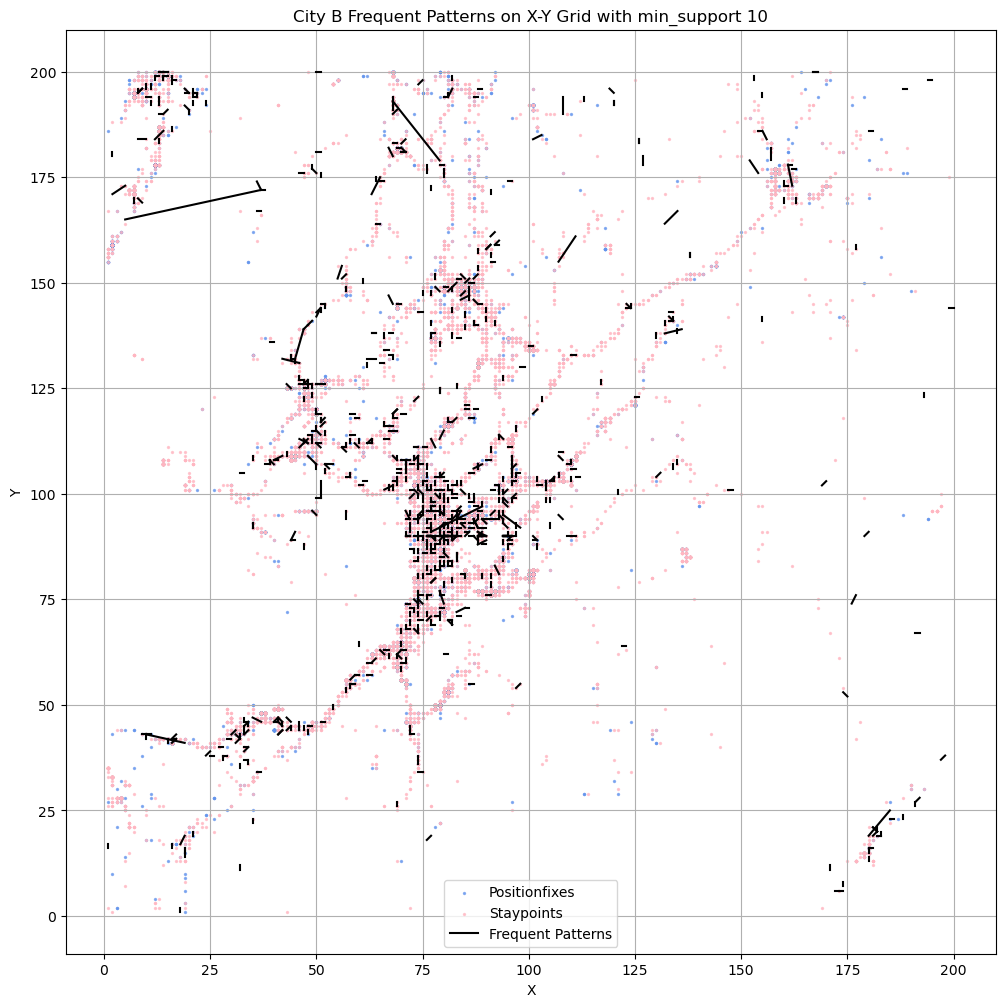

In [35]:
# Visualize top patterns
# Extract positionfixes and staypoints from a subset of processed data for visualization
positionfixes = pfs_chunk[pfs_chunk['staypoint_id'].isna()][:500000]
staypoints = pfs_chunk.dropna(subset=['staypoint_id'])[:500000]

plt.figure(figsize=(12, 12))
plt.scatter(positionfixes['x'], positionfixes['y'], label='Positionfixes', color='#6495ED', s=2, alpha=0.7)
plt.scatter(staypoints['x'], staypoints['y'], label='Staypoints', color='#FFB6C1', s=2, alpha=0.7)

# Plot each frequent pattern
for pattern, count in all_frequent_patterns.items():
    x_coords = [point[0] for point in pattern]
    y_coords = [point[1] for point in pattern]
    plt.plot(x_coords, y_coords, linestyle='-', alpha=1, linewidth=1.5, color='black')

# Add a legend entry for triplegs
plt.plot([], [], linestyle='-', color='black', label='Frequent Patterns')

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'City B Frequent Patterns on X-Y Grid with min_support {min_support}')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Convert the frequent patterns to a DataFrame for easier saving
patterns_df = pd.DataFrame({
    'Pattern': [pattern for pattern in all_frequent_patterns.keys()],
    'Count': [count for count in all_frequent_patterns.values()]
})

In [33]:
patterns_df.head()

,Pattern,Count
0,"((89.0, 77.0),)",10
1,"((80.0, 95.0),)",10
2,"((80.0, 104.0),)",10
3,"((67.0, 180.0),)",10
4,"((74.0, 75.0),)",10


In [32]:
# Save the patterns to a CSV file
patterns_df.to_csv("CityB_frequent_patterns_minsup10.csv", index=False)

In [34]:
# Check for long patterns
long_patterns = patterns_df[patterns_df['Pattern'].apply(len) >= 5]

# Display the result
long_patterns

,Pattern,Count
2717,"((81.0, 90.0), (80.0, 90.0), (81.0, 90.0), (80...",10
2982,"((76.0, 90.0), (77.0, 90.0), (76.0, 90.0), (77...",10
